In [1]:
%matplotlib inline

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [3]:
import os
import re

# ----------------- Classics -------------------- #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)



############## NLP STUFF ##############
import spacy
nlp = spacy.load('en_core_web_lg')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis.gensim

/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packag

### Load the `reviews`

In [4]:
!rm -rf "./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
!unzip "../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip" -d "./data" 

Archive:  ../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
  inflating: ./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  
   creating: ./data/__MACOSX/
  inflating: ./data/__MACOSX/._Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [7]:
fpath = "data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"

reviews = pd.read_csv(fpath)
reviews.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [9]:
STOPWORDS = set(STOPWORDS).union(set(['amazon']))

def tokenize(text):
    return [token for token in simple_preprocess(text, deacc=True, min_len=4, max_len=20) if token not in STOPWORDS]

In [10]:
def wrangle(df):
    new_df = df.copy()
    new_df['brand'] = new_df['brand'].apply(lambda x: x.lower())
    new_df['tokens'] = new_df['reviews.text'].apply(tokenize)
    new_df = new_df[['brand', 'reviews.text', 'tokens']]
    return new_df

df = wrangle(reviews)
df.head()

,brand,reviews.text,tokens
0,amazonbasics,I order 3 of them and one of the item is bad q...,"[order, item, quality, missing, backup, spring..."
1,amazonbasics,Bulk is always the less expensive way to go fo...,"[bulk, expensive, products, like]"
2,amazonbasics,Well they are not Duracell but for the price i...,"[duracell, price, happy]"
3,amazonbasics,Seem to work as well as name brand batteries a...,"[work, brand, batteries, better, price]"
4,amazonbasics,These batteries are very long lasting the pric...,"[batteries, long, lasting, price, great]"


In [17]:
df.loc[0, 'reviews.text']

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

### Gensim LDA Topic Modeling

In [32]:
def get_reviews(df, token_col):
    
    assert token_col in df.columns, f"{token_col} does not exist!"
    
    for index, row in df.iterrows():
        review_token = row[token_col]
        yield review_token

In [33]:
id2word = corpora.Dictionary(get_reviews(df, 'tokens'))
id2word.token2id['batteries']

16

In [21]:
sample_tokens = tokenize("I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.")
sample_tokens

['order',
 'item',
 'quality',
 'missing',
 'backup',
 'spring',
 'aluminum',
 'battery',
 'work']

In [22]:
id2word.doc2bow(sample_tokens)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [34]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(tokens) for tokens in get_reviews(df, 'tokens')]
corpus[0][:10]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [23]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [24]:
lda.print_topics()

[(0,
  '0.061*"purchase" + 0.026*"happy" + 0.018*"pleased" + 0.017*"working" + 0.014*"works" + 0.013*"exactly" + 0.012*"described" + 0.012*"worked" + 0.012*"needed" + 0.011*"arrived"'),
 (1,
  '0.029*"great" + 0.028*"alexa" + 0.025*"music" + 0.022*"sound" + 0.020*"echo" + 0.019*"speaker" + 0.016*"good" + 0.016*"portable" + 0.011*"like" + 0.011*"bluetooth"'),
 (2,
  '0.102*"good" + 0.096*"batteries" + 0.082*"price" + 0.059*"great" + 0.056*"work" + 0.044*"long" + 0.031*"quality" + 0.026*"brand" + 0.021*"brands" + 0.014*"deal"'),
 (3,
  '0.036*"batteries" + 0.024*"good" + 0.012*"charge" + 0.008*"hold" + 0.008*"better" + 0.008*"battery" + 0.008*"actually" + 0.007*"like" + 0.007*"duracell" + 0.006*"dead"'),
 (4,
  '0.041*"love" + 0.038*"bought" + 0.024*"grandkids" + 0.020*"expected" + 0.019*"christmas" + 0.016*"sure" + 0.015*"charging" + 0.013*"going" + 0.011*"port" + 0.010*"issues"'),
 (5,
  '0.112*"batteries" + 0.016*"long" + 0.015*"battery" + 0.013*"brand" + 0.011*"work" + 0.011*"time" +

In [25]:
def print_lda_topics(lda):
    words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
    topics = [' '.join(t[0:5]) for t in words]
    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
print_lda_topics(lda)

------ Topic 0 ------
purchase happy pleased working works

------ Topic 1 ------
great alexa music sound echo

------ Topic 2 ------
good batteries price great work

------ Topic 3 ------
batteries good charge hold better

------ Topic 4 ------
love bought grandkids expected christmas

------ Topic 5 ------
batteries long battery brand work

------ Topic 6 ------
kindle easy screen love tablet

------ Topic 7 ------
battery life charge time kindle

------ Topic 8 ------
kids tablet love great year

------ Topic 9 ------
great value good like fast

------ Topic 10 ------
tablet best google store play

------ Topic 11 ------
great price tablet good works

------ Topic 12 ------
great product recommend tablet apps

------ Topic 13 ------
loves bought year books gift

------ Topic 14 ------
good tablet great games nice



### Topic Distance Visualization

In [26]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [27]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.242713  0.065999       1        1  12.562837
6      0.171477  0.064618       2        1  10.040983
2     -0.249730 -0.149088       3        1   9.547331
8      0.197309  0.001222       4        1   9.218286
13     0.214038  0.154702       5        1   8.412799
11     0.021871 -0.222049       6        1   6.867417
14     0.120020 -0.159710       7        1   6.344353
12     0.136987 -0.083874       8        1   6.228317
10     0.084397 -0.012459       9        1   5.980581
7     -0.062179  0.119562      10        1   5.422487
1     -0.040855 -0.031945      11        1   4.453681
3     -0.218887  0.075310      12        1   4.225827
9     -0.021284 -0.122997      13        1   3.923345
0     -0.128122  0.098765      14        1   3.695921
4      0.017672  0.201944      15        1   3.075842, topic_info=     Category         Freq            Term        Total  loglift  logprob
16    Default  7011.000000       batteries  7011.000000  30.0000  30.0000
19    Default  8743.000000           great  8743.000000  29.0000  29.0000
15    Default  4758.000000           price  4758.000000  28.0000  28.0000
30    Default  5658.000000            good  5658.000000  27.0000  27.0000
2424  Default  2088.000000           loves  2088.000000  26.0000  26.0000
3888  Default  6961.000000          tablet  6961.000000  25.0000  25.0000
179   Default  2445.000000            kids  2445.000000  24.0000  24.0000
2922  Default  2895.000000          kindle  2895.000000  23.0000  23.0000
8     Default  2235.000000            work  2235.000000  22.0000  22.0000
2     Default  2026.000000         battery  2026.000000  21.0000  21.0000
25    Default  3096.000000          bought  3096.000000  20.0000  20.0000
81    Default  3411.000000            love  3411.000000  19.0000  19.0000
35    Default   987.000000        purchase   987.000000  18.0000  18.0000
711   Default  1705.000000           games  1705.000000  17.0000  17.0000
21    Default  2314.000000            long  2314.000000  16.0000  16.0000
399   Default   988.000000           value   988.000000  15.0000  15.0000
92    Default  1758.000000            year  1758.000000  14.0000  14.0000
155   Default  1870.000000         product  1870.000000  13.0000  13.0000
206   Default  1301.000000            best  1301.000000  12.0000  12.0000
831   Default  2912.000000            easy  2912.000000  11.0000  11.0000
156   Default  1042.000000       recommend  1042.000000  10.0000  10.0000
18    Default  1171.000000           brand  1171.000000   9.0000   9.0000
2935  Default  1423.000000           books  1423.000000   8.0000   8.0000
27    Default   881.000000       christmas   881.000000   7.0000   7.0000
6     Default  1386.000000         quality  1386.000000   6.0000   6.0000
2079  Default  1598.000000          screen  1598.000000   5.0000   5.0000
1488  Default   918.000000        daughter   918.000000   4.0000   4.0000
1899  Default  1849.000000            apps  1849.000000   3.0000   3.0000
51    Default   997.000000            life   997.000000   2.0000   2.0000
5552  Default   481.000000          google   481.000000   1.0000   1.0000
138    Topic1   132.866821     controllers   133.790024   2.0675  -5.5854
424    Topic1   213.002502         remotes   214.636444   2.0668  -5.1134
105    Topic1   102.026558         candles   103.263680   2.0624  -5.8495
475    Topic1    88.378571      controller    89.452415   2.0624  -5.9931
621    Topic1    50.442017         leaking    51.336224   2.0569  -6.5539
802    Topic1    42.530636          clocks    43.419716   2.0537  -6.7245
550    Topic1    61.945145          leaked    63.242310   2.0537  -6.3485
1303   Topic1    40.312199            acid    41.186401   2.0530  -6.7781
459    Topic1    35.824024        kirkland    36.705608   2.0501  -6.8961
120    Topic1    25.963339           trail    26.861839   2.0404  -7.2181
1442 

In [35]:
cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
print(f'Coherence score: {cm.get_coherence()}')

Coherence score: -3.251272484720278


In [71]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, df, token_col, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    tokens = list(get_reviews(df, token_col))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            
            model_list.append(model)
            
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return model_list, coherence_values

In [72]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        df=df,
                                                        token_col='tokens',
                                                        start=2, 
                                                        limit=14, 
                                                        step=1,
                                                        passes=5)

In [73]:
len(coherence_values), len(model_list)

(60, 60)

In [74]:
coherence_values[0]

{'pass': 0, 'num_topics': 2, 'coherence_score': -2.7867203730257204}

In [75]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,coherence_score,num_topics,pass
0,-2.786720,2,0
1,-2.780618,3,0
2,-2.794260,4,0
3,-2.863813,5,0
4,-2.887780,6,0


/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


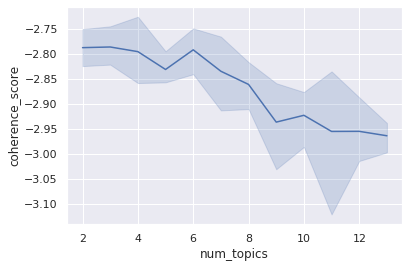

In [76]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [77]:
best_lda = model_list[2]

In [78]:
#Visualize LDA
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_lda, corpus, id2word)#, sort=False)

/home/ubuntu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.032153 -0.059066       1        1  28.294300
1      0.024054 -0.010430       2        1  28.245323
3      0.062723  0.018304       3        1  23.297136
2     -0.054624  0.051192       4        1  20.163246, topic_info=     Category         Freq           Term        Total  loglift  logprob
3888  Default  6665.000000         tablet  6665.000000  30.0000  30.0000
19    Default  8876.000000          great  8876.000000  29.0000  29.0000
1899  Default  2040.000000           apps  2040.000000  28.0000  28.0000
2922  Default  3063.000000         kindle  3063.000000  27.0000  27.0000
15    Default  4933.000000          price  4933.000000  26.0000  26.0000
81    Default  3716.000000           love  3716.000000  25.0000  25.0000
2471  Default   881.000000           ipad   881.000000  24.0000  24.0000
8     Default  2177.000000           work  2177.000000  23.0000  23.0000
2079  Default  1705.000000         screen  1705.000000  22.0000  22.0000
831   Default  3201.000000           easy  3201.000000  21.0000  21.0000
454   Default   840.000000           deal   840.000000  20.0000  20.0000
2424  Default  2361.000000          loves  2361.000000  19.0000  19.0000
206   Default  1435.000000           best  1435.000000  18.0000  18.0000
2935  Default  1585.000000          books  1585.000000  17.0000  17.0000
27    Default   988.000000      christmas   988.000000  16.0000  16.0000
30    Default  5661.000000           good  5661.000000  15.0000  15.0000
16    Default  6991.000000      batteries  6991.000000  14.0000  14.0000
35    Default   966.000000       purchase   966.000000  13.0000  13.0000
399   Default  1035.000000          value  1035.000000  12.0000  12.0000
86    Default  1462.000000          works  1462.000000  11.0000  11.0000
2340  Default   191.000000        present   191.000000  10.0000  10.0000
2906  Default   195.000000          email   195.000000   9.0000   9.0000
2470  Default   240.000000          cover   240.000000   8.0000   8.0000
3040  Default   253.000000       charging   253.000000   7.0000   7.0000
11    Default  2433.000000           like  2433.000000   6.0000   6.0000
25    Default  3279.000000         bought  3279.000000   5.0000   5.0000
4300  Default   214.000000          likes   214.000000   4.0000   4.0000
155   Default  1977.000000        product  1977.000000   3.0000   3.0000
1488  Default  1037.000000       daughter  1037.000000   2.0000   2.0000
1477  Default   378.000000           book   378.000000   1.0000   1.0000
2353   Topic1    27.179031       exceeded    29.423616   1.1832  -7.9842
514    Topic1     9.463636      birthdays    10.297861   1.1780  -9.0392
3807   Topic1    12.168430          sucks    13.410989   1.1653  -8.7878
4241   Topic1     9.103479      accessing    10.235681   1.1453  -9.0780
648    Topic1    11.860894           boot    13.497019   1.1333  -8.8134
2898   Topic1     6.070306          pricy     6.929162   1.1302  -9.4832
2902   Topic1    10.110749     accidently    11.633480   1.1222  -8.9731
3784   Topic1     6.020673         talked     6.928888   1.1220  -9.4915
911    Topic1     6.792692     comforting     7.820488   1.1216  -9.3708
3109   Topic1     4.931231        xfinity     5.702200   1.1172  -9.6911
6574   Topic1     4.819330      graphical     5.604800   1.1115  -9.7140
3888   Topic1  5728.150879         tablet  6665.810547   1.1109  -2.6335
2663   Topic1    14.163099         thinks    16.598141   1.1039  -8.6360
4371   Topic1     9.400830          fight    11.017103   1.1039  -9.0459
2755   Topic1    24.594801         expand    28.872747   1.1021  -8.0841
2934   Topic1     8.856955       strongly    10.408286   1.1011  -9.1054
1122   Topic1     4.824020        buzzing     5.688000   1.0978  -9.7130
3879   Topic1     5.335810     lackluster     6.310824   1.0947  -9.6122
3081   Topic1     4.887386      locations     5.791043  

## Findings

There seem to be a lot of reviews that's centered around battery/batteries and kindle tablets. Also, some keywords are kindle, tablet, love, and price. Combined with the 15 topics that LDA chose, it seems Amazon's tablet is a hit from the first impression. And as with normal consumer behavior, people care about price and value and tend to buy things as gift, especially during Christmas.

In [79]:
# !rm -rf "./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling